# Извлечение золота. Описание проекта.
## Технологический процесс. Добыча золота из руды.
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.
### Опишем каждую стадию:

1. Флотация.
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.

На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка.
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Описание данных
### Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- - Xanthate — ксантогенат (промотер, или активатор флотации);
- - Sulphate — сульфат (на данном производстве сульфид натрия);
- - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

### Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

### Наименование признаков
Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
*Пример:* rougher.input.feed_ag
#### Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

#### Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Расчёт эффективности
Нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле: 

#### recovery = (C*(F-T)) / (F*(C-T)) * 100%

где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

## Метрика качества sMAPE
Для решения задачи введём метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

<img src=https://i.stack.imgur.com/YIy33.png>

Или 
#### 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:
#### Итоговое sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(final)

# Подготовка данных

In [136]:
# Импорт стандартной библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb

# Сторонний импорт
from datetime import date
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')


In [137]:
df_list = {'data':[gold_recovery_train_new, gold_recovery_test_new, gold_recovery_full_new],
           'name':['gold_recovery_train_new', 'gold_recovery_test_new', 'gold_recovery_full_new']}
for data_index in range(3):
    print()
    print('--------------------------------------------------------',df_list['name'][data_index],'--------------------------------------------------------')
    df_list['data'][data_index].info()
    display(df_list['data'][data_index].head())
    print()
    display(df_list['data'][data_index].describe())
    print()
    print('========================================================================================================================================================================')
    print()



-------------------------------------------------------- gold_recovery_train_new --------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459





-------------------------------------------------------- gold_recovery_test_new --------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.st

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487





-------------------------------------------------------- gold_recovery_full_new --------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


In [138]:
# Расчет эффективности обогащения recovery
data = gold_recovery_train_new
C = data['rougher.output.concentrate_au']
F = data['rougher.input.feed_au']
T = data['rougher.output.tail_au']
recovery = (C*(F-T)) / (F*(C-T)) * 100  # Прогноз расчета эффективности обогащения чернового концентрата


In [139]:
# Проверка правильности расчета эффективности обогащения
print('gold_recovery_train_new')
data = gold_recovery_train_new

target_valid = data['final.output.recovery']
print(mean_absolute_error(target_valid,recovery))

target_valid = data['rougher.output.recovery']
print(mean_absolute_error(target_valid,recovery))

(data.assign(recovery = recovery)
 .head()[['final.output.recovery','recovery','rougher.output.recovery']])


gold_recovery_train_new
19.217082377275947
9.73512347450521e-15


,final.output.recovery,recovery,rougher.output.recovery
0,70.541216,87.107763,87.107763
1,69.266198,86.843261,86.843261
2,68.116445,86.842308,86.842308
3,68.347543,87.226430,87.226430
4,66.927016,86.688794,86.688794


**Расчет эффективности обогащения верный.**

In [140]:
# Проанализируем признаки, недоступные в тестовой выборке gold_recovery_test_new: что это за параметры, к какому типу относятся.

test_sample_columns = gold_recovery_test_new.columns.tolist()
print(pd.DataFrame({'test_sample_columns':gold_recovery_test_new.columns}))
print()
print('---------------------------------------------------------')
print('test_sample_columns:', len(gold_recovery_test_new.columns))

full_sample_columns = gold_recovery_full_new.columns.tolist()
print('full_sample_columns:', len(gold_recovery_full_new.columns))

(unique_columns = pd.DataFrame({'unique_columns':full_sample_columns})
    .query('unique_columns not in @test_sample_columns')
    .reset_index(drop=True))
print('unique_columns:',len(unique_columns))
print()
print('---------------------------------------------------------')
print(unique_columns)


                           test_sample_columns
0                                         date
1                primary_cleaner.input.sulfate
2             primary_cleaner.input.depressant
3              primary_cleaner.input.feed_size
4               primary_cleaner.input.xanthate
5       primary_cleaner.state.floatbank8_a_air
6     primary_cleaner.state.floatbank8_a_level
7       primary_cleaner.state.floatbank8_b_air
8     primary_cleaner.state.floatbank8_b_level
9       primary_cleaner.state.floatbank8_c_air
10    primary_cleaner.state.floatbank8_c_level
11      primary_cleaner.state.floatbank8_d_air
12    primary_cleaner.state.floatbank8_d_level
13                       rougher.input.feed_ag
14                       rougher.input.feed_pb
15                     rougher.input.feed_rate
16                     rougher.input.feed_size
17                      rougher.input.feed_sol
18                       rougher.input.feed_au
19           rougher.input.floatbank10_sulfate
20          r

Проанализируем признаки, недоступные в тестовой выборке gold_recovery_test_new: что это за параметры, к какому типу относятся.

**В тестовой выборке недоступны признаки: концентратов, хвостов, расчета эффективности обогащения и его прогноза, металлов (Au, Ag, Pb)**

**Содержит параметры этапов:**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи
- информацию о флотационных реагентах: Xanthate, Sulphate, Depressant

**Тестовая выборка содержит вторичную информацию. Расчет эффективности обогащения `recovery` и итоговое sMAPE по ней не расчитать.**

### Предобработка данных. Заполнение пропусков медианой. Предобработка времени. Добавим целевые признаки для gold_recovery_test_new из gold_recovery_full_new.

In [141]:
# Предобработка данных. Заполнение пропусков медианой. Предобработка времени.
for data_index in range(3):
    
    data = df_list['data'][data_index]
    data.date = pd.to_datetime(data.date, format='%Y-%m-%d') # Предобработка времени из object в datetime64
    for col in data.columns.drop('date'):
        data[col] = data[col].fillna(method="ffill")
        
# Заполняем gold_recovery_test_new целевыми признаками из gold_recovery_full_new.
# необходимые данные из gold_recovery_full_new для объединения с gold_recovery_test_new
targets = ['date', 'rougher.output.recovery', 'final.output.recovery']
# добавляем целеевые признаки по дате
gold_recovery_test_new = (gold_recovery_test_new.merge(gold_recovery_full_new.loc[:,targets], 
                                                       on='date', 
                                                       how='inner'))

# Из обучающей удаляем лишние признаки (которые отсутствуют в тестовой, кроме целевых)
test_sample_columns = gold_recovery_test_new.columns.drop('date').tolist() # новый список колонок тестовой таблицы
gold_recovery_train_new = gold_recovery_train_new.loc[:,test_sample_columns] # удаляем лишние признаки
gold_recovery_test_new = gold_recovery_test_new.drop('date', axis=1) # удаляем date


## Заключение предобработки:
- В таблицах пропуски. Заполнили их методом ffill;
- Расчет эффективности обогащения верный;
- Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
- Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.


# Анализ данных

In [142]:
# суммируем все металлы в один столбец по стадиям
rougher_input_feed = [] # все столбцы rougher_input_feed.{металл} суммированы в один столбец rougher_input_feed
rougher_output_concentrate = []
final_output_concentrate = []
for m in gold_recovery_full_new.columns:
    if 'rougher.input.feed' in m:
        rougher_input_feed.append(m)
    elif 'rougher.output.concentrate' in m:
        rougher_output_concentrate.append(m)
    elif 'final.output.concentrate' in m:
        final_output_concentrate.append(m)

rougher_input_feed = ['rougher.input.feed_ag','rougher.input.feed_pb',
                      'rougher.input.feed_sol','rougher.input.feed_au']
stages = [rougher_input_feed, rougher_output_concentrate, final_output_concentrate]

rougher_input_feed = (gold_recovery_full_new.loc[:,stages[0][0]] 
                      + gold_recovery_full_new.loc[:,stages[0][1]] 
                      + gold_recovery_full_new.loc[:,stages[0][2]]  
                      + gold_recovery_full_new.loc[:,stages[0][3]])

rougher_output_concentrate = (gold_recovery_full_new.loc[:,stages[1][0]] 
                              + gold_recovery_full_new.loc[:,stages[1][1]] 
                              + gold_recovery_full_new.loc[:,stages[1][2]]  
                              + gold_recovery_full_new.loc[:,stages[1][3]])

final_output_concentrate = (gold_recovery_full_new.loc[:,stages[2][0]] 
                            + gold_recovery_full_new.loc[:,stages[2][1]] 
                            + gold_recovery_full_new.loc[:,stages[2][2]]  
                            + gold_recovery_full_new.loc[:,stages[2][3]])

stages = (pd.DataFrame(data=rougher_input_feed, columns=['sum_all_metals_rougher_input_feed'])
              .assign(sum_all_metals_rougher_output_concentrate = rougher_output_concentrate, 
                      sum_all_metals_final_output_concentrate = final_output_concentrate))
display(stages)


,sum_all_metals_rougher_input_feed,sum_all_metals_rougher_output_concentrate,sum_all_metals_final_output_concentrate
0,51.680034,66.424950,63.644396
1,50.659114,67.012710,63.957723
2,50.609929,66.103793,64.311180
3,51.061546,65.752751,63.573449
4,47.859163,65.908382,64.004667
...,...,...,...
19434,53.415050,70.781325,68.098589
19435,53.696482,70.539603,68.274362
19436,54.589604,55.376330,68.226068
19437,54.027355,69.201689,68.200449


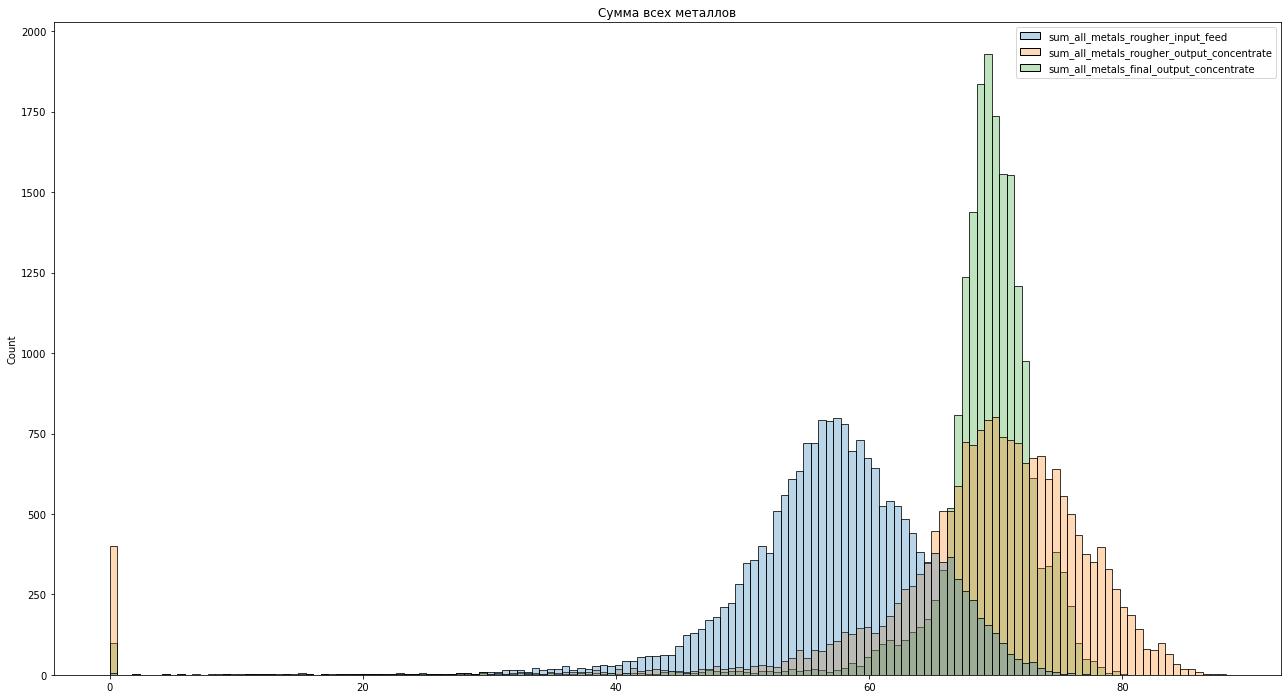

In [143]:
plt.figure(figsize=(22,12))
sns.histplot(data=stages, alpha=0.3).set(title='Сумма всех металлов');

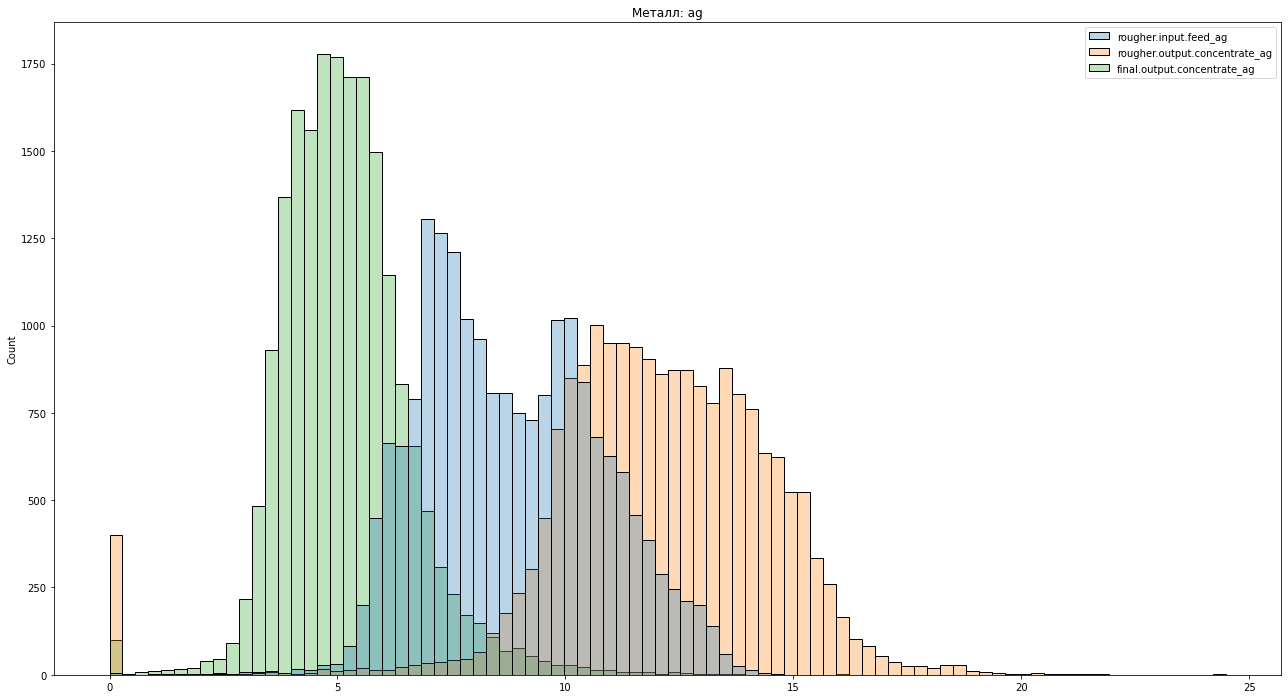

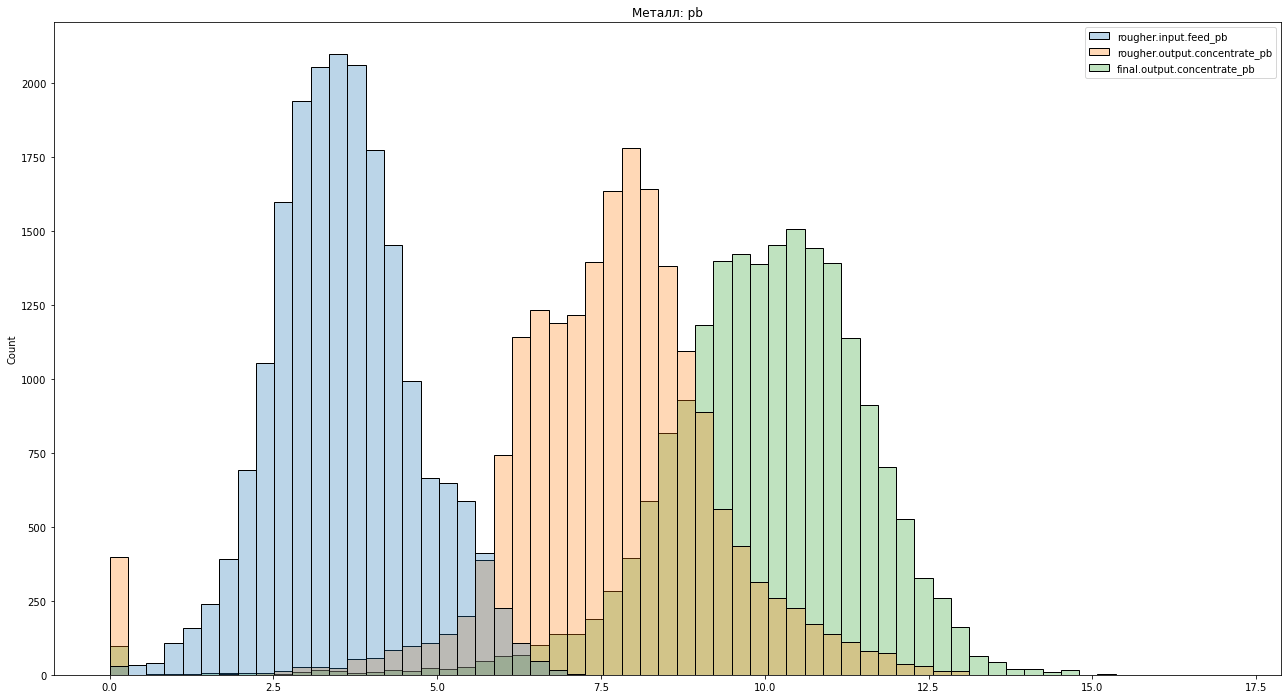

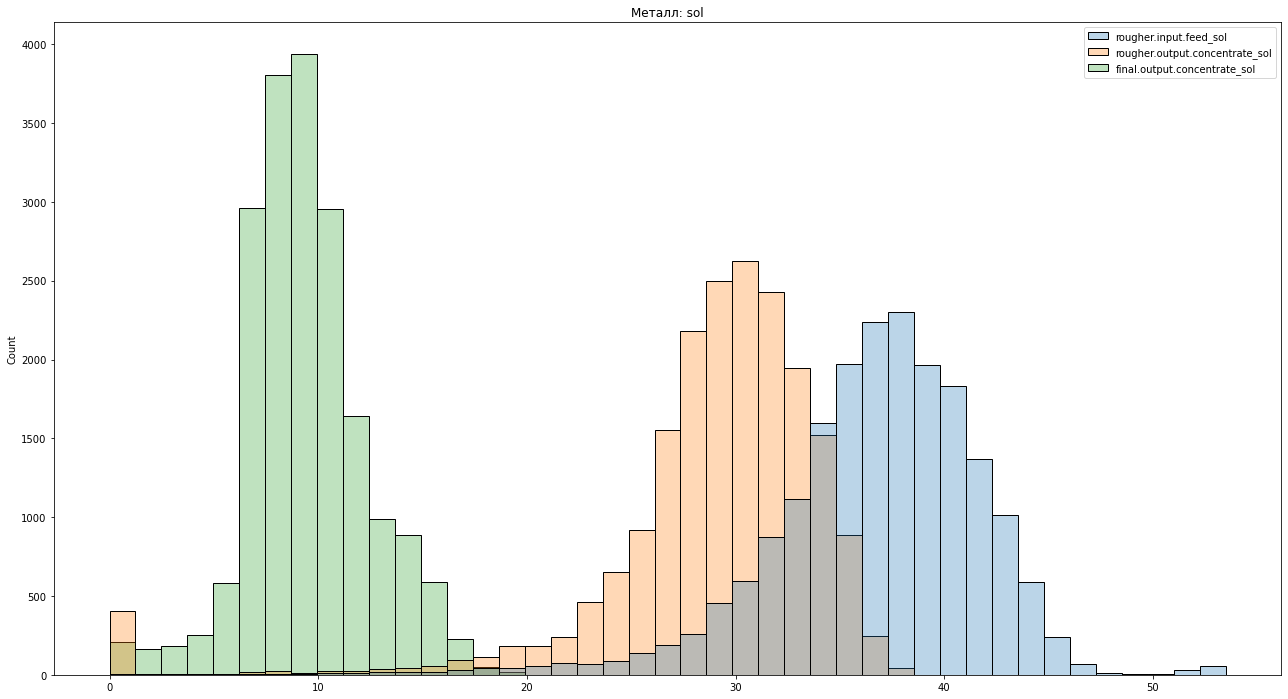

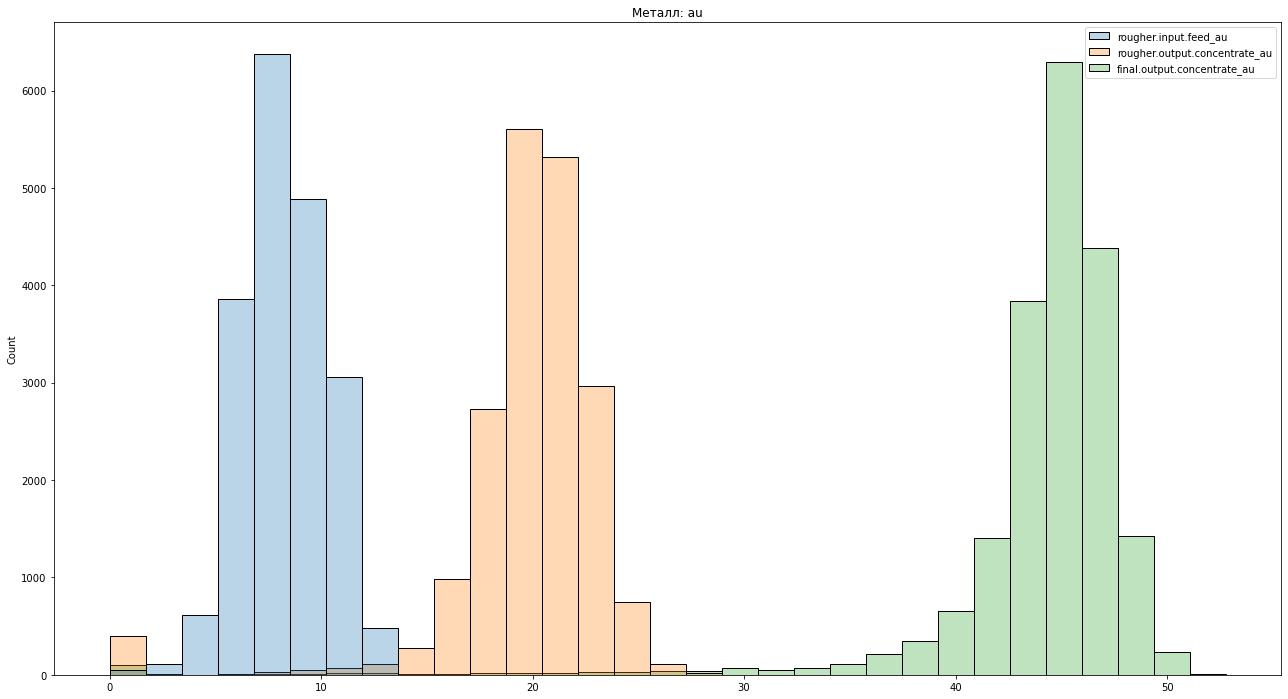

In [144]:
def metal_histplot(metal):
    data = (gold_recovery_full_new.loc[:,['rougher.input.feed_'+metal, 
                                          'rougher.output.concentrate_'+metal,
                                          'final.output.concentrate_'+metal]])
    plt.figure(figsize=(22,12))
    sns.histplot(data=data, alpha=0.3).set(title=('Металл: '+metal));

metal_histplot('ag')
metal_histplot('pb')
metal_histplot('sol')
metal_histplot('au')


**Концентрация `Ag` плавно падает от стадии к стадии. `Pb` плавно растет. `sol` резко падает после финальной стадии. `Au` резко и четко меняет концентрацию от стадии к стадии в сторону роста.**

In [145]:
# Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.
# feed size — размер гранул сырья
feed_size = []
for col in gold_recovery_train_new.columns:
    if 'feed_size' in col:
        feed_size.append(col)
print(feed_size)


['primary_cleaner.input.feed_size', 'rougher.input.feed_size']


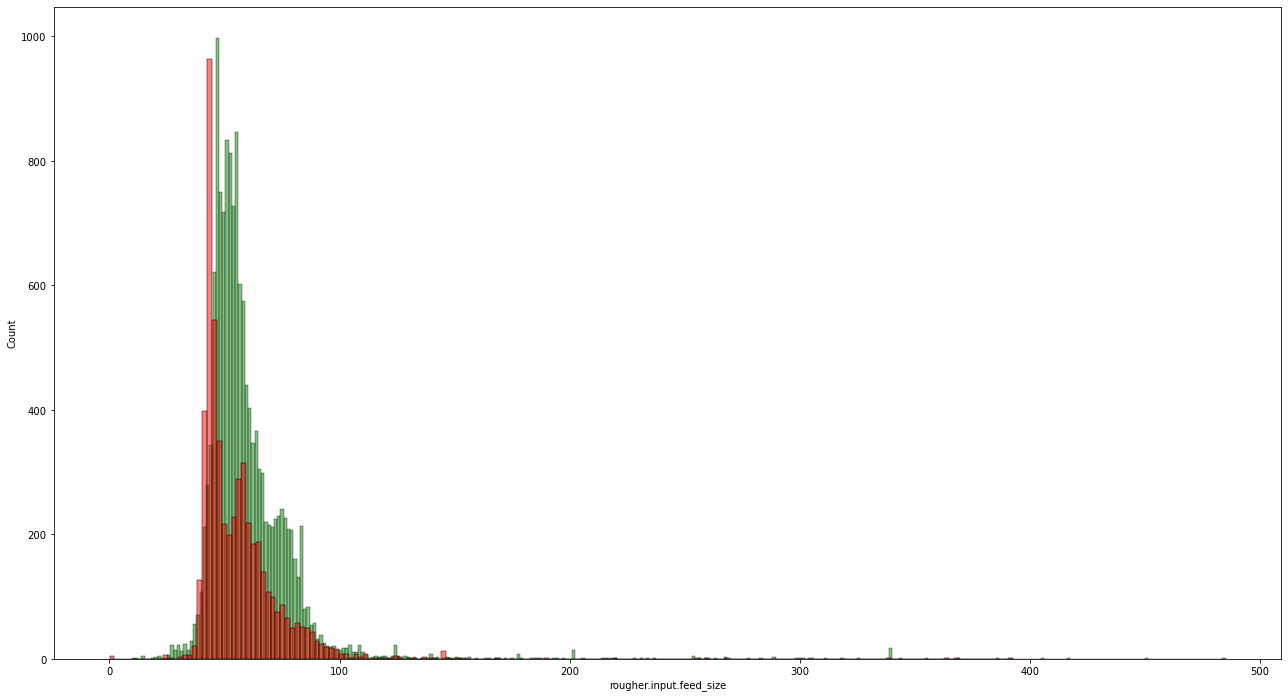

In [146]:
plt.figure(figsize=(22,12))
sns.histplot(gold_recovery_train_new['rougher.input.feed_size'], color='green', alpha=0.5)
sns.histplot(gold_recovery_test_new['rougher.input.feed_size'], color='red', alpha=0.5);


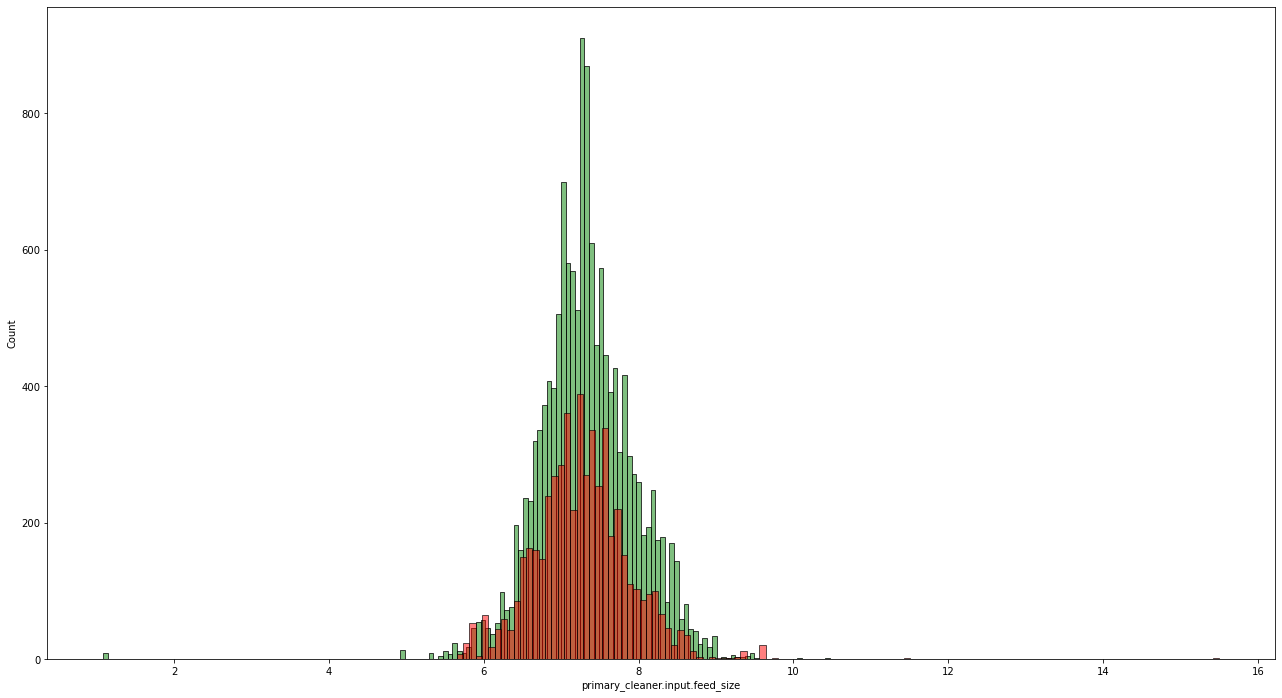

In [147]:
plt.figure(figsize=(22,12))
sns.histplot(gold_recovery_train_new['primary_cleaner.input.feed_size'], color='green', alpha=0.5)
sns.histplot(gold_recovery_test_new['primary_cleaner.input.feed_size'], color='red', alpha=0.5);


## Результат анализа:
- Концентрация `серебра (Ag)` плавно падает от стадии к стадии. `Свинца (Pb)` плавно растет. `sol` резко падает после финальной стадии. `Золота (Au)` резко и четко меняет концентрацию от стадии к стадии в сторону роста.
- В целом, распределения размеров гранул сырья не сильно отличаются друг от друга, следовательно оценка модели будет правильной;

## 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

# Построение модели

In [148]:
# Обучим разные модели и оценим их качество кросс-валидацией.

def samples(target): # Определяем целевой признак. Выбор между 'rougher.output.recovery' и 'final.output.recovery'
    data = gold_recovery_train_new
    features = data.drop([target], axis=1)
    target = data[target].astype('int')
    return features, target

def smape(y_true, y_pred): # Метрика качества sMAPE
    A, F = y_true, y_pred
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

score = make_scorer(smape, greater_is_better=False)

def final_smape(target0,target1): # Итоговое sMAPE
    X_train, y_train = samples(target0)
    smape_rougher = model.fit(X_train, y_train)
    X_train, y_train = samples(target1)
    smape_final = model.fit(X_train, y_train)
    f_smape = .25*smape_rougher.best_score_ + .75*smape_final.best_score_
    print('Итоговое sMAPE:',f_smape)
    

In [149]:
param_grid = {
"max_depth": range(2,6)
}

# Grid Search CV implementation
GBR = GradientBoostingRegressor()
model = HalvingGridSearchCV(GBR, param_grid, scoring=score, 
                            n_jobs=-1, min_resources="exhaust", cv=3)

# Return set of parameters with the best performance
final_smape('rougher.output.recovery','final.output.recovery')


Итоговое sMAPE: -10.97366675699726


## Проверка на тестовой выборке

In [150]:
def samples_test(target): # Определяем целевой признак. Выбор между 'rougher.output.recovery' и 'final.output.recovery'
    data = gold_recovery_test_new # заменим массив на тестовый
    features = data.drop([target], axis=1)
    target = data[target].astype('int')
    return features, target

def test(target):
    X_train, y_train = samples(target)
    model.fit(X_train, y_train)
    X_test, y_test = samples_test(target)
    y_pred = model.predict(X_test)
    test_smape = smape(y_test, y_pred)
    return test_smape

# Выбираем лучшую модель и проверим её на тестовой выборке.
test_smape_rougher = test('rougher.output.recovery')
test_smape_final = test('final.output.recovery')
f_smape = .25*test_smape_rougher + .75*test_smape_final

print('Итоговое sMAPE:',f_smape)


Итоговое sMAPE: 8.440526092346325


# Итог
- Ввели значения метрик расчёта эффективности обогащения (восстановления металла из содержащей руды) recovery и симметричное среднее абсолютное процентное отклонение `sMAPE`;
- Таблицы `gold_recovery_full_new` (данные для кросс валидации) и `gold_recovery_test_new` (данные для тестов) имеют общие данные начиная с `2016-09-01`, но `full` содержит больше признаков. Некоторые параметры замеряются и/или рассчитываются значительно позже;
- Концентрация золота (`Au`) и свинца (`Pb`) растет от этапа к этапу, серебра (`Ag`) и `sol` падает;
- Распределения размеров гранул сырья на обучающей и тестовой выборках слабо отличаются друг от друга, следовательно оценка модели будет правильной;
- Оценка качества модели `sMAPE` примерно равна от `8` до `-10`. Тест провели.